In [1]:
import matplotlib
preamble = [
    r'\usepackage{fontspec}',
    r'\setmainfont{Linux Libertine O}',
]
fontsize = 17
ticklen = 5
params = {
    'font.size': fontsize,
    'axes.titlesize': fontsize,
    'xtick.labelsize': fontsize,
    'ytick.labelsize': fontsize,
    'axes.labelsize': fontsize,
    'legend.fontsize': fontsize,
    'text.usetex': True,
    'pgf.rcfonts': False,
    'pgf.texsystem': 'xelatex',
    'pgf.preamble': preamble,
    'xtick.major.size' : ticklen,
    'ytick.major.size' : ticklen,
    'xtick.minor.size' : ticklen/2,
    'ytick.minor.size' : ticklen/2
}
matplotlib.rcParams.update(params)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import decimal

import astropy.constants as const
from astropy.table import Table, Column
from astropy.io import fits
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd

In [4]:
def compute_T0(planet):
    if os.path.exists('../masterfile.ecsv'):
        data = Table.to_pandas(Table.read('../masterfile.ecsv'))
    else:
        print('ERROR: No previously downloaded Exoplanet Archive data - try again when you are connected to the internet.')
        print(FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), '../masterfile.ecsv'))
        exit()

    names = np.array(data['pl_hostname'])+np.array(data['pl_letter'])
    names = np.array([name.replace(' ','').replace('-', '').replace('_','') for name in names])

    nameIndex = np.where(names==planet.replace(' ','').replace('-', '').split('_')[0])[0][0]
    
    if np.isfinite(data['pl_ratdor'][nameIndex]):
        a = data['pl_ratdor'][nameIndex]
        a_err = np.mean([data['pl_ratdorerr1'][nameIndex],
                                -data['pl_ratdorerr2'][nameIndex]])
    else:
        a = data['pl_orbsmax'][nameIndex]*const.au.value/data['st_rad'][nameIndex]/const.R_sun.value
        a_err = np.sqrt(
            (np.mean([data['pl_orbsmaxerr1'][nameIndex], -data['pl_orbsmaxerr2'][nameIndex]])*const.au.value
             /data['st_rad'][nameIndex]/const.R_sun.value)**2
            + (data['pl_orbsmax'][nameIndex]*const.au.value
               /data['st_rad'][nameIndex]**2/const.R_sun.value
               *np.mean([data['st_raderr1'][nameIndex], -data['st_raderr2'][nameIndex]]))**2
        )
    
    Tstar = data['st_teff'][nameIndex]
    Tstar_err = np.mean([data['st_tefferr1'][nameIndex],
                                -data['st_tefferr2'][nameIndex]])

    nIters = 10000
    Tstar = np.random.normal(Tstar, Tstar_err, nIters)
    a = np.random.normal(a, a_err, nIters)
    
    T0 = Tstar*np.sqrt(1/a)
    return np.array([np.median(T0), np.std(T0)])

In [5]:
mainpath   = '/home/taylor/Documents/Research/spitzer/MEGA/'
planets = np.array(['HD189733b', 'WASP-43b', 'Qatar-1b', 'HD209458b', 'CoRoT-2b',
                    'WASP-14b', 'WASP-19b', 'HAT-P-7b', 'WASP-18b', 'KELT-1b',
                    'KELT-16b', 'WASP-103b', 'MASCARA-1b', 'WASP-12b', 'WASP-12b_old',
                    'WASP-33b', 'KELT-9b'])
channels = ['ch2' for planet in planets]
temp_planets = ['_{'.join(planet.split('_'))+'}' if '_' in planet else planet for planet in planets]
fancy_planets = np.array([r'$\rm '+r'$-$\rm '.join(planet.split('-'))+r'$' for planet in temp_planets])

fancy_planets = fancy_planets.astype('<U30')
fancy_planets[fancy_planets=='$\\rm WASP$-$\\rm 12b_{old}$'] = '$\\rm WASP$-$\\rm 12b~(2010)$'
fancy_planets[fancy_planets=='$\\rm WASP$-$\\rm 12b$'] = '$\\rm WASP$-$\\rm 12b~(2013)$'\

twoLimits = True

In [6]:
plotMode = 'BLISS_v2_autoRun_POET'
fancy_labels = r'$\rm '+r'\textunderscore '.join(plotMode.split('_'))+r'$'

In [15]:
T0s = []
As = []
Bs = []
fps = []
offsets = []
rps = []
tNights = []
tDays = []
sigFs = []
sigF_photons = []
modeBICs = []
folders = []

for iterNum in range(len(planets)):
    channel = channels[iterNum]
    planet = planets[iterNum]

    # Figure out where files are saved
    phoption = ''
    foldername = ''
    rms = None
    with open(f'{mainpath}{planet}/analysis/{channel}/bestPhOption.txt') as f:
        lines = f.readlines()
    for i in range(len(lines)):
        if phoption=='' and lines[i][0]=='/':
            foldername = mainpath+lines[i][lines[i].find(planet):].strip()+'/'
            phoption = lines[i].split('/')[-1].strip()
            i += 1
            ignoreFrames = np.array(lines[i].strip().split('=')[1].strip().replace(' ','').split(','))
            if np.all(ignoreFrames==['']):
                ignoreFrames = np.array([]).astype(int)
            else:
                ignoreFrames = ignoreFrames.astype(int)
            i += 1
            rms = float(lines[i])
        elif phoption!='' and lines[i][0]=='/':
            if float(lines[i+2]) < rms:
                foldername = mainpath+lines[i][lines[i].find(planet):].strip()+'/'
                phoption = lines[i].split('/')[-1].strip()
                i += 1
                ignoreFrames = np.array(lines[i].split('=')[1].strip().replace(' ','').split(','))
                if np.all(ignoreFrames==['']):
                    ignoreFrames = np.array([]).astype(int)
                else:
                    ignoreFrames = ignoreFrames.astype(int)
                i += 1
                rms = float(lines[i])
            else:
                i += 3
    pldFoldernames = np.array(['/'.join(foldername.split('/')[:-2])+'/'+np.array(x)[0].split('/')[-1]+'/' for x in os.walk('/'.join(foldername.split('/')[:-2])+'/') if '4umPLD' in x[0].split('/')[-1] or '3umPLD' in x[0].split('/')[-1]])

    # Figure out what modes were run
    modes = np.sort([x[0].split('/')[-1] for x in os.walk(foldername)][1:])
    for i in range(len(pldFoldernames)):
        modes = np.append(modes, np.sort([x[0].split('/')[-1] for x in os.walk(pldFoldernames[i])][1:]))
    
    if planet in ['CoRoT-2b', 'WASP-12b', 'WASP-12b_old', 'WASP-103b']:
        modes = np.array([mode for mode in modes if plotMode.replace('_POET','').replace('_unbinned','')==mode[:len(plotMode.replace('_POET','').replace('_unbinned',''))]])
    else:
        modes = np.array([mode for mode in modes if plotMode==mode[:len(plotMode)]])

    # If this method was not fully run for this planet+channel, skip it
    if len(modes)==0:
        print(plotMode, 'not run for', planet, channel)
        T0s.append([np.nan, np.nan])
        As.append([np.nan, np.nan, np.nan])
        Bs.append([np.nan, np.nan, np.nan])
        fps.append([np.nan, np.nan, np.nan])
        offsets.append([np.nan, np.nan, np.nan])
        rps.append([np.nan, np.nan, np.nan])
        tNights.append([np.nan, np.nan, np.nan])
        tDays.append([np.nan, np.nan, np.nan])
        sigFs.append([np.nan, np.nan, np.nan])
        sigF_photons.append(np.nan)
        modeBICs.append(np.nan)
        folders.append('None')
        continue

    BICs = []
    for mode in modes:
        if 'PLD' in plotMode:
            if channel=='ch2':
                folder='4um'
            else:
                folder='3um'
            if '3x3' in mode:
                folder += 'PLD_3x3/'
            else:
                folder += 'PLD_5x5/'
            savepath   = '/'.join(foldername.split('/')[:-2])+'/'+folder + mode + '/'+ 'ResultMCMC_'+mode+'_Params.npy'
        else:
            savepath   = foldername + mode + '/'+ 'ResultMCMC_'+mode+'_Params.npy'

        if not os.path.exists(savepath):
            BICs.append(np.nan)
        else:
            ResultMCMC = np.load(savepath)
            BICs.append(-2*ResultMCMC['evidenceB'][0])

    if np.all(np.isnan(BICs)):
        T0s.append([np.nan, np.nan])
        As.append([np.nan, np.nan, np.nan])
        Bs.append([np.nan, np.nan, np.nan])
        fps.append([np.nan, np.nan, np.nan])
        offsets.append([np.nan, np.nan, np.nan])
        rps.append([np.nan, np.nan, np.nan])
        tNights.append([np.nan, np.nan, np.nan])
        tDays.append([np.nan, np.nan, np.nan])
        sigFs.append([np.nan, np.nan, np.nan])
        sigF_photons.append(np.nan)
        modeBICs.append(np.nan)
        folders.append('None')
        continue

    mode = modes[np.nanargmin(BICs)]

    if 'PLD' in plotMode:
        if channel=='ch2':
            folder='4um'
        else:
            folder='3um'
        if '3x3' in mode:
            folder += 'PLD_3x3/'
        else:
            folder += 'PLD_5x5/'
        savepath   = '/'.join(foldername.split('/')[:-2])+'/'+folder + mode + '/'+ 'ResultMCMC_'+mode+'_Params.npy'
    else:
        savepath   = foldername + mode + '/'+ 'ResultMCMC_'+mode+'_Params.npy'

    ResultMCMC = np.load(savepath)

    if planet=='KELT-1b':
        T0s.append([6518/np.sqrt(3.60), np.sqrt((50/np.sqrt(3.60))**2+(6518/(3.60)*0.04)**2)])
    else:
        T0s.append(compute_T0(planet))
    fps.append(ResultMCMC['fp']*1e6)
    offsets.append(ResultMCMC['offset'])
    rps.append(ResultMCMC['rp'])
    tNights.append(ResultMCMC['tNight'])
    tDays.append(ResultMCMC['tDay'])
    if planet=='MASCARA-1b' and 'PyMC3' in mode:
        As.append(ResultMCMC['A']*np.pi/2)
        Bs.append(-ResultMCMC['B']*np.pi/2)
        sigFs.append(ResultMCMC['sigF']*1e6)
    else:
        As.append(ResultMCMC['A'])
        Bs.append(ResultMCMC['B'])
        sigFs.append(ResultMCMC['sigF']*1e6)
    try:
        sigF_photons.append(ResultMCMC['sigF_photon_ppm'][0])
    except:
        if planet=='MASCARA-1b':
            sigF_photons.append(509/2.124)
        elif planet=='KELT-16b':
            sigF_photons.append(1642/1.799)
        else:
            sigF_photons.append(np.nan)
    modeBICs.append(BICs[np.nanargmin(BICs)])

    folders.append('/'.join(savepath.split('/')[:-1]))

    print(planet, channel, mode)

T0s = np.array(T0s).T
As = np.array(As).T
Bs = np.array(Bs).T
fps = np.array(fps).T
offsets = np.array(offsets).T
rps = np.array(rps).T
tNights = np.array(tNights).T
tDays = np.array(tDays).T
sigFs = np.array(sigFs).T
sigF_photons = np.array(sigF_photons)
modeBICs = np.array(modeBICs)
folders = np.array(folders)

order = np.argsort(T0s[0])

T0s = T0s[:,order]
As = As[:,order]
Bs = Bs[:,order]
fps = fps[:,order]
offsets = offsets[:,order]
rps = rps[:,order]
tNights = tNights[:,order]
tDays = tDays[:,order]
sigFs = sigFs[:,order]
sigF_photons = sigF_photons[order]
modeBICs = modeBICs[order]
folders = folders[order]
planets = planets[order]
fancy_planets = fancy_planets[order]

HD189733b ch2 BLISS_v2_autoRun_POET
WASP-43b ch2 BLISS_v2_autoRun_POET
Qatar-1b ch2 BLISS_v2_autoRun_POET
HD209458b ch2 BLISS_v2_autoRun_POET
CoRoT-2b ch2 BLISS_v2_autoRun
WASP-14b ch2 BLISS_v2_autoRun_POET
WASP-19b ch2 BLISS_v2_autoRun_POET
HAT-P-7b ch2 BLISS_v2_autoRun_POET
WASP-18b ch2 BLISS_v2_autoRun_POET
KELT-1b ch2 BLISS_v2_autoRun_POET
KELT-16b ch2 BLISS_v2_autoRun_POET
MASCARA-1b ch2 BLISS_v2_autoRun_POET
WASP-12b ch2 BLISS_v2_autoRun
WASP-12b_old ch2 BLISS_v2_autoRun
WASP-33b ch2 BLISS_v2_autoRun_POET
KELT-9b ch2 BLISS_v2_autoRun_POET
BLISS_v2_autoRun_POET not run for WASP-103b ch2


In [16]:
T0 = T0s.T[np.isfinite(T0s[0])]
Td = tDays.T[np.isfinite(T0s[0])]
Tn = tNights.T[np.isfinite(T0s[0])]
offset = offsets.T[np.isfinite(T0s[0])]
planets_temp = planets[np.isfinite(T0s[0])]
fancy_planets_temp = fancy_planets[np.isfinite(T0s[0])]

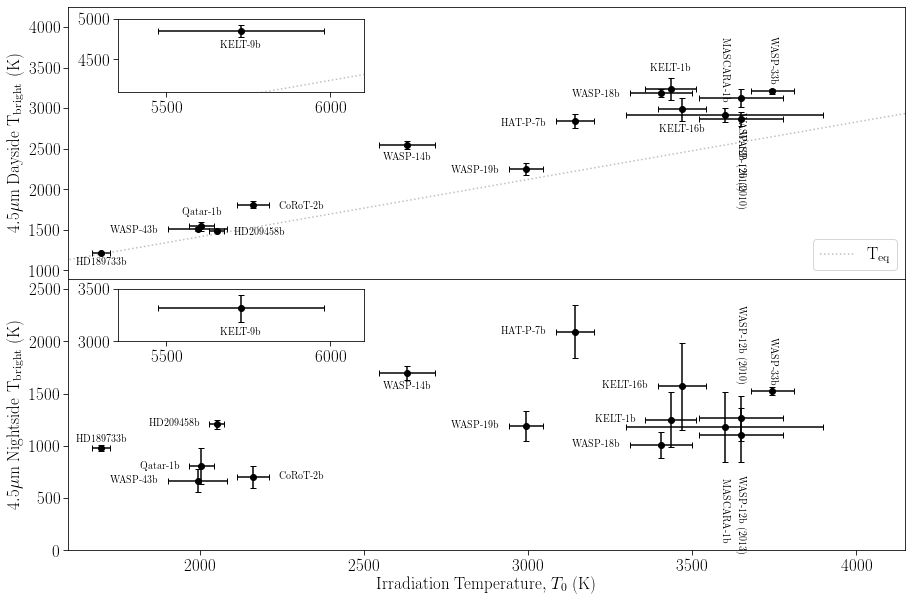

In [17]:
fig, ax = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0}, figsize=(15,10))

ax[0].errorbar(T0[:,0], Td[:,0], xerr=T0[:,1], yerr=Td[:,1], fmt='o', color='k', capsize=3)
ax[0].plot([1000,4500], np.array([1000,4500])*0.25**0.25, c='grey', ls='dotted', alpha=0.5, label=r'$\rm T_{eq}$')
left=[1,6,7,8]
top=[2,9]
bottom=[0,5,10]
rotright=[12,13]
rotrightup=[11,14]
for i in range(len(planets_temp)-1):
    if i in left:
        ax[0].text(T0[i,0]-T0[i,1]-30, Td[i,0]-30, fancy_planets_temp[i], ha='right', va='center')
    elif i in top:
        ax[0].text(T0[i,0], Td[i,0]+Td[i,1]+60, fancy_planets_temp[i], ha='center', va='bottom')
    elif i in bottom:
        ax[0].text(T0[i,0], Td[i,0]-Td[i,1]-60, fancy_planets_temp[i], ha='center', va='top')
    elif i in rotright:
        ax[0].text(T0[i,0], Td[i,0]-Td[i,1]-60, fancy_planets[i], ha='center', va='top', rotation=-90)    
    elif i in rotrightup:
        ax[0].text(T0[i,0], Td[i,0]+Td[i,1]+60, fancy_planets[i], ha='center', va='bottom', rotation=-90)    
    else:
        ax[0].text(T0[i,0]+T0[i,1]+30, Td[i,0]-30, fancy_planets_temp[i], ha='left', va='center')
ax[0].set_xlim(1600,4150)
ax[0].set_ylim(900,4250)
ax[0].set_ylabel(r'$\rm 4.5\mu m~Dayside~T_{bright}~(K)$')
ax[0].set_xlabel(r'${\rm Irradiation~Temperature,}~T_{\rm 0} ~({\rm K})$')
ax[0].legend(loc=4)
axin1 = ax[0].inset_axes([1750, 3200, 750, 900], transform=ax[0].transData)
axin1.errorbar(T0[:,0][-1], Td[:,0][-1], xerr=T0[:,1][-1], yerr=Td[:,1][-1], fmt='o', color='k', capsize=3)
axin1.text(T0[-1,0], Td[-1,0]-Td[-1,1]-60, fancy_planets_temp[-1], ha='center', va='top')
axin1.plot([1000,6500], np.array([1000,6500])*0.25**0.25, c='grey', ls='dotted', alpha=0.5)
axin1.set_xlim(T0[-1,0]-750/2,T0[-1,0]+750/2)
axin1.set_xticks([5500,6000])
axin1.set_ylim(4100,5000)

ax[1].errorbar(T0[:,0], Tn[:,0], xerr=T0[:,1], yerr=Tn[:,1], fmt='o', color='k', capsize=3)
left=[1,2,3,6,7,8,9,10]
top=[0]
bottom=[5]
rotright=[11,13]
rotrightup=[12,14]
for i in range(len(planets_temp)-1):
    if i in left:
        ax[1].text(T0[i,0]-T0[i,1]-30, Tn[i,0]+0, fancy_planets_temp[i], ha='right', va='center')
    elif i in top:
        ax[1].text(T0[i,0], Tn[i,0]+Tn[i,1]*1.5, fancy_planets_temp[i], ha='center', va='bottom')
    elif i in bottom:
        ax[1].text(T0[i,0], Tn[i,0]-Tn[i,1]*1.5, fancy_planets_temp[i], ha='center', va='top')
    elif i in rotright:
        ax[1].text(T0[i,0], Tn[i,0]-Tn[i,1]*1.5, fancy_planets[i], ha='center', va='top', rotation=-90)    
    elif i in rotrightup:
        ax[1].text(T0[i,0], Tn[i,0]+Tn[i,1]*1.5, fancy_planets[i], ha='center', va='bottom', rotation=-90)    
    else:
        ax[1].text(T0[i,0]+T0[i,1]+30, Tn[i,0]+0, fancy_planets_temp[i], ha='left', va='center')
ax[1].set_ylim(0,2600)
ax[1].set_ylabel(r'$\rm 4.5\mu m~Nightside~T_{bright}~(K)$')
ax[1].set_xlabel(r'${\rm Irradiation~Temperature,}~T_{\rm 0} ~({\rm K})$')
axin2 = ax[1].inset_axes([1750, 2000, 750, 500], transform=ax[1].transData)
axin2.errorbar(T0[:,0][-1], Tn[:,0][-1], xerr=T0[:,1][-1], yerr=Tn[:,1][-1], fmt='o', color='k', capsize=3)
axin2.text(T0[-1,0], Tn[-1,0]-Tn[-1,1]*1.5, fancy_planets_temp[-1], ha='center', va='top')
axin2.set_xlim(T0[-1,0]-750/2,T0[-1,0]+750/2)
axin2.set_xticks([5500,6000])
axin2.set_ylim(3000,3500)

plt.savefig('../MEGA/figures/Tb_T0_Uniform.pdf', bbox_inches='tight')

plt.show()

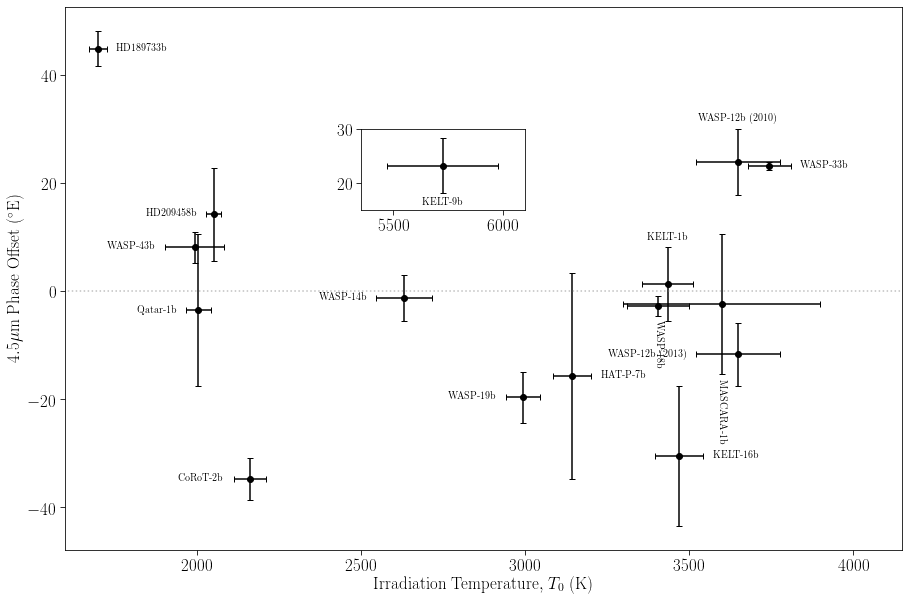

In [18]:
plt.figure(figsize=(15,10))
plt.errorbar(T0[:,0], offset[:,0], xerr=T0[:,1], yerr=offset[:,1], fmt='o', color='k', capsize=3)
left=[1,2,3,4,5,6,13]
bottom=[]
top=[9,12]
rotright=[8,11]
rotrightup=[]
for i in range(len(planets_temp)-1):
    if i in left:
        plt.text(T0[i,0]-T0[i,1]-30, offset[i,0]+0, fancy_planets_temp[i], ha='right', va='center')
    elif i in top:
        plt.text(T0[i,0], offset[i,0]+offset[i,1]+1, fancy_planets_temp[i], ha='center', va='bottom')
    elif i in bottom:
        plt.text(T0[i,0], offset[i,0]-offset[i,1]-1, fancy_planets_temp[i], ha='center', va='top')
    elif i in rotright:
        plt.text(T0[i,0], offset[i,0]-offset[i,1]-1, fancy_planets[i], ha='center', va='top', rotation=-90)    
    elif i in rotrightup:
        plt.text(T0[i,0], offset[i,0]+offset[i,1]+1, fancy_planets[i], ha='center', va='bottom', rotation=-90)    
    else:
        plt.text(T0[i,0]+T0[i,1]+30, offset[i,0]+0, fancy_planets_temp[i], ha='left', va='center')

plt.plot([1500,4150],[0,0],c='grey',ls='dotted',alpha=0.5)
plt.xlim(1600,4150)

ax = plt.gca()
axin1 = ax.inset_axes([2500, 15, 500, 15], transform=ax.transData)
axin1.errorbar(T0[:,0][-1], offset[:,0][-1], xerr=T0[:,1][-1], yerr=offset[:,1][-1], fmt='o', color='k', capsize=3)
axin1.text(T0[-1,0], offset[-1,0]-offset[-1,1]-1, fancy_planets_temp[-1], ha='center', va='top')
axin1.set_xlim(T0[-1,0]-750/2,T0[-1,0]+750/2)
axin1.set_xticks([5500,6000])
axin1.set_ylim(15,30)


plt.ylabel(r'$\rm 4.5\mu m~Phase~Offset~(^{\circ}E)$')
plt.xlabel(r'${\rm Irradiation~Temperature,}~T_{\rm 0} ~({\rm K})$')

plt.savefig('../MEGA/figures/offset_T0_Uniform.pdf', bbox_inches='tight')
plt.show()